In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import Birch,KMeans
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
df = pd.read_csv("in_index.csv")
df['Dates']  = pd.to_datetime(df['Dates'])
print(df.shape)
df.tail(2)

(429, 22)


,Dates,NAPMPMI Index,Initial Jobless Claims,Non Farm Payroll,Labor Force Participation Index,University of Michigan Confidence,GDP QOQ Index,FEDL01 Index,Diff_2_10,SP_price,...,HS,Gold_price,Gold,FTSE_price,FTSE,DJ_price,DJ,AGG_price,AGG,diff_10_2
427,2019-07-31,51.2,217,166,63.0,98.4,2.0,2.40,0.06,2980.38,...,-0.026797,1427.55,0.013165,7586.78,0.021702,26864.27,0.009936,2176.49,0.002201,0.06
428,2019-08-31,49.1,219,219,63.2,89.8,2.0,2.13,0.05,2926.46,...,-0.073909,1528.40,0.070646,7207.18,-0.050034,26403.28,-0.017160,2232.89,0.025913,0.05


### Load Recession Data

In [3]:
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1910, 1, 1), end=datetime(2019, 9, 1))
usrec.head()

,USREC
DATE,
1910-01-01,0
1910-02-01,1
1910-03-01,1
1910-04-01,1
1910-05-01,1


### Recession Averages 

In [4]:
rec2 = usrec.reset_index()
rec2['USREC2'] = np.where(rec2['USREC'] == 1, 'Recession', 'No Recession')
rec2['count'] = (rec2.USREC.diff(1) != 0).astype('int').cumsum()
rec_data = pd.DataFrame({'BeginDate' : rec2.groupby('count').DATE.first(), 
              'EndDate' : rec2.groupby('count').DATE.last(),
              'Consecutive' : rec2.groupby('count').size(), 
              'Economy' : rec2.groupby('count').USREC2.first()}).reset_index(drop=True)

rec_data = rec_data[1:]
print('Since 1910 Average Time in  and out of Recession')
print(rec_data.groupby('Economy').mean())
print('==' *10)
print('Count')
print(rec_data['Economy'].value_counts())

print('--' * 40)

rec_data2 = rec_data[19:]
print('Since 1949 Average Time in  and out of Recession')
print(rec_data2.groupby('Economy').mean())
print('==' *10)
print('Count')
print(rec_data2['Economy'].value_counts())

print('--' * 40)

rec_data3 = rec_data[30:]
print('Since 1980 Average Time in  and out of Recession')
print(rec_data3.groupby('Economy').mean())
print('==' *10)
print('Count')
print(rec_data3['Economy'].value_counts())


print('--' * 40)

rec_data4 = rec_data[33:]
print('Since 1982 Average Time in  and out of Recession')
print(rec_data4.groupby('Economy').mean())
print('==' *10)
print('Count')
print(rec_data4['Economy'].value_counts())

Since 1910 Average Time in  and out of Recession
              Consecutive
Economy                  
No Recession        51.55
Recession           14.25
Count
Recession       20
No Recession    20
Name: Economy, dtype: int64
--------------------------------------------------------------------------------
Since 1949 Average Time in  and out of Recession
              Consecutive
Economy                  
No Recession    66.181818
Recession       11.100000
Count
No Recession    11
Recession       10
Name: Economy, dtype: int64
--------------------------------------------------------------------------------
Since 1980 Average Time in  and out of Recession
              Consecutive
Economy                  
No Recession         84.0
Recession            11.2
Count
Recession       5
No Recession    5
Name: Economy, dtype: int64
--------------------------------------------------------------------------------
Since 1982 Average Time in  and out of Recession
              Consecutive
Economy  

### Clean Dataset

In [5]:
df2 = df[['Dates', 'NAPMPMI Index', 'Initial Jobless Claims', 'Non Farm Payroll',
       'Labor Force Participation Index', 'University of Michigan Confidence',
       'GDP QOQ Index', 'FEDL01 Index', 'Diff_2_10']]
df2 = df2[1:]
df2.reset_index(inplace = True)
df2.drop('index', inplace=True, axis=1)
df2.head(2)

,Dates,NAPMPMI Index,Initial Jobless Claims,Non Farm Payroll,Labor Force Participation Index,University of Michigan Confidence,GDP QOQ Index,FEDL01 Index,Diff_2_10
0,1984-01-31,60.5,364,443,63.9,100.1,8.6,9.56,1.05
1,1984-02-29,61.3,343,484,64.1,97.4,8.6,9.59,1.01


### Functions

In [6]:
def plot_cluster(x,y,t, clow, chigh, mlow, mhigh):
    sns.set()
    plt.figure(figsize = (20,10))
    plt.plot(x, y)
    plt.axhline(clow, color='r', linestyle='--',lw =3, label = 'Cluster Split')
    plt.axhline(chigh, color='r', linestyle='--',lw =3)
    plt.axhline(mlow, color='k', linestyle='-',lw =3)
    plt.axhline(mhigh, color='k', linestyle='-',lw =3, label = 'Mean +/- SD')
    plt.title('Cluster 3 ' + t, fontsize = 30)
    plt.xlabel('Date', fontsize = 20)
    plt.ylabel(t, fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.fill_between(usrec.index, min(y), max(y), where=usrec['USREC'].values, color='gray', alpha=0.3)
    plt.xlim(x[4],x[-1])
    plt.legend()
    
from dateutil import relativedelta
def get_months(x,y):
    rr = (x - y).days
    months = round(rr/30)
    return(months)

## Clustering Indicators

###  Non Fram Payroll

In [7]:
nfp = df2[['Dates', 'Non Farm Payroll']].set_index('Dates')
nfp.head()

,Non Farm Payroll
Dates,
1984-01-31,443
1984-02-29,484
1984-03-31,272
1984-04-30,363
1984-05-31,306


In [8]:
X = nfp['Non Farm Payroll'].values.reshape(-1, 1)
sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)
X_scaled[:3]

array([[0.93193717],
       [0.96260284],
       [0.80403889]])

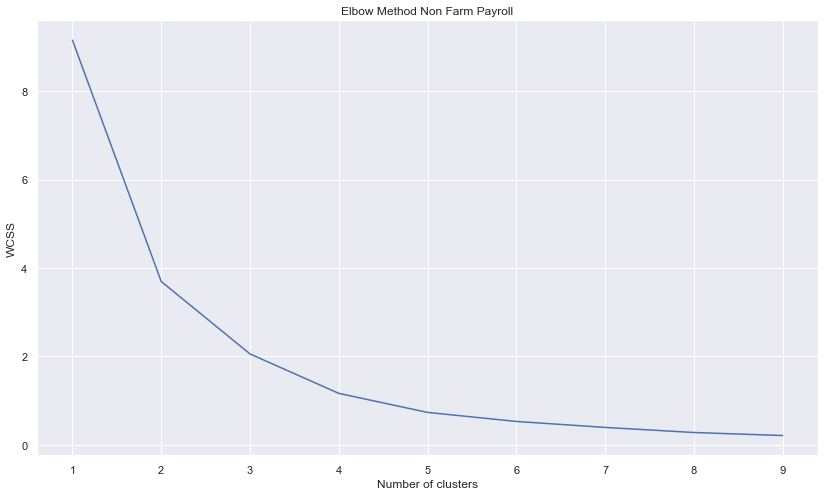

In [9]:
wcss = []
sns.set()
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(14,8))
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method Non Farm Payroll')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
kmeans2 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred = kmeans2.fit_predict(X_scaled)
nfp['label'] = pred
score3 = silhouette_score(X_scaled, pred, metric='euclidean', random_state = 0)
print('Silhouette:',score3)

Silhouette: 0.5549507325684607


In [11]:
# range of clusters
print(nfp.groupby('label').agg(['max', 'min']))
print('=='*40)

mm = nfp['Non Farm Payroll'].mean()
sd = nfp['Non Farm Payroll'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)


      Non Farm Payroll     
                   max  min
label                      
0                 -184 -803
1                  141 -166
2                  534  144
Mean: 138.80140186915887
STD: +/- 195.72606747056332
Upper: 334.5274693397222
Lower: -56.924665601404456


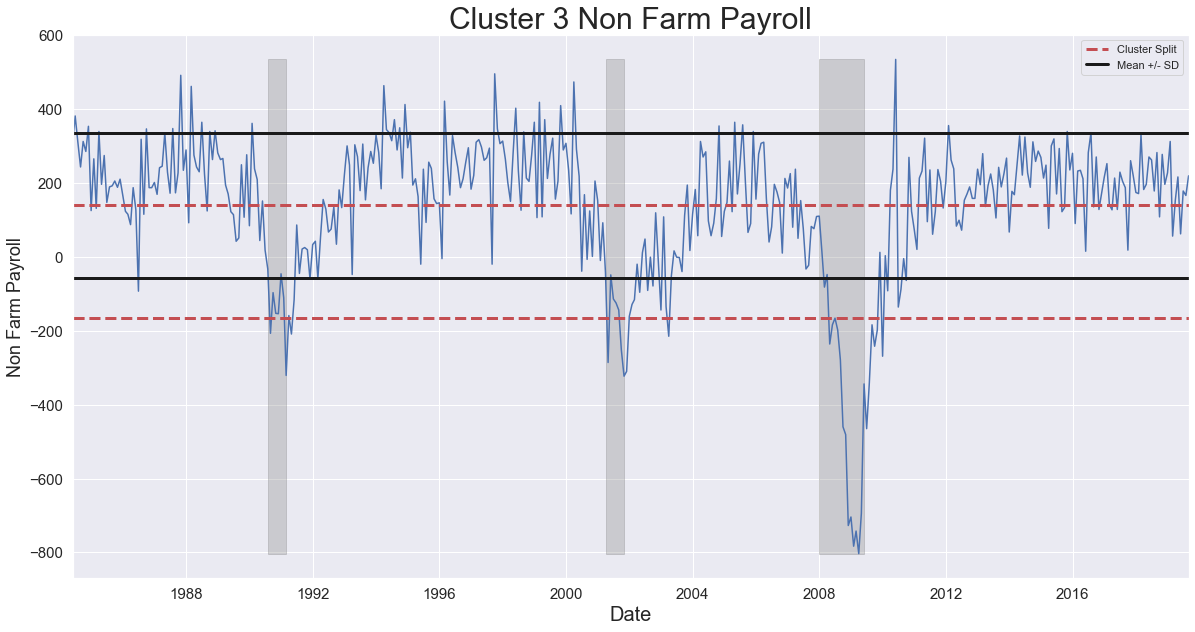

In [12]:
plot_cluster(nfp.index, nfp['Non Farm Payroll'],'Non Farm Payroll' , clow = -166, chigh = 141,
             mlow = -56.924665601404456, mhigh = 334.5274693397222)

### University of Michigan Confidence 

### Cluster 3

In [13]:
mic = df2[['Dates', 'University of Michigan Confidence']].set_index('Dates')
mic.head(2)

,University of Michigan Confidence
Dates,
1984-01-31,100.1
1984-02-29,97.4


In [14]:
X2 = mic['University of Michigan Confidence'].values.reshape(-1,1)
sc2 = MinMaxScaler()
X_scaled2 = sc2.fit_transform(X2)
X_scaled2[:3]

array([[0.79012346],
       [0.74250441],
       [0.80599647]])

In [15]:
kmeans2 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred2 = kmeans2.fit_predict(X_scaled2)
mic['label_3'] = pred2
score = silhouette_score(X_scaled2, pred2, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.5174705694773083


In [16]:
# range of clusters
print(mic.groupby('label_3').agg(['max', 'min']))
print('==' *40)

mm = mic['University of Michigan Confidence'].mean()
sd = mic['University of Michigan Confidence'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)

        University of Michigan Confidence      
                                      max   min
label_3                                        
0                                    94.8  80.3
1                                    80.0  55.3
2                                   112.0  94.9
Mean: 88.51775700934576
STD: +/- 11.586730786559611
Upper: 100.10448779590537
Lower: 76.93102622278614


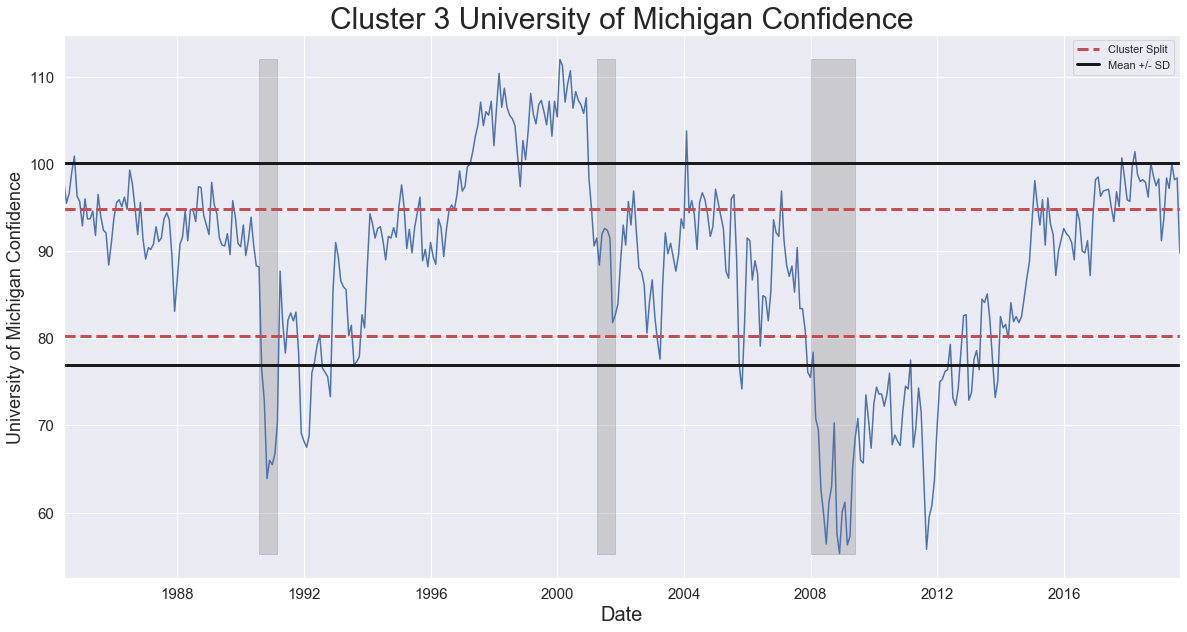

In [17]:
plot_cluster(mic.index,mic['University of Michigan Confidence'],  'University of Michigan Confidence',
            clow = 80.3, chigh =94.8, mlow = 76.93102622278614, mhigh = 100.10448779590537 )

### Jobless Claims

In [18]:
ijc = df2[['Dates', 'Initial Jobless Claims']].set_index('Dates')
ijc.head()

,Initial Jobless Claims
Dates,
1984-01-31,364
1984-02-29,343
1984-03-31,341
1984-04-30,375
1984-05-31,354


In [19]:
X3 = ijc['Initial Jobless Claims'].values.reshape(-1,1)
sc3 = MinMaxScaler()
X_scaled3 = sc3.fit_transform(X3)
X_scaled3[:3]

array([[0.34707158],
       [0.30151844],
       [0.29718004]])

In [20]:
kmeans_ijc = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred_ijc = kmeans_ijc.fit_predict(X_scaled3)
ijc['label_3'] = pred_ijc
score = silhouette_score(X_scaled3, pred_ijc, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.5056813393998572


In [21]:
### range of Clusters
print(ijc.groupby('label_3').agg(['max', 'min']))
print('==' *40)

mm = ijc['Initial Jobless Claims'].mean()
sd = ijc['Initial Jobless Claims'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)


        Initial Jobless Claims     
                           max  min
label_3                            
0                          425  327
1                          665  429
2                          326  204
Mean: 351.7920560747664
STD: +/- 72.83069605622562
Upper: 424.622752130992
Lower: 278.96136001854074


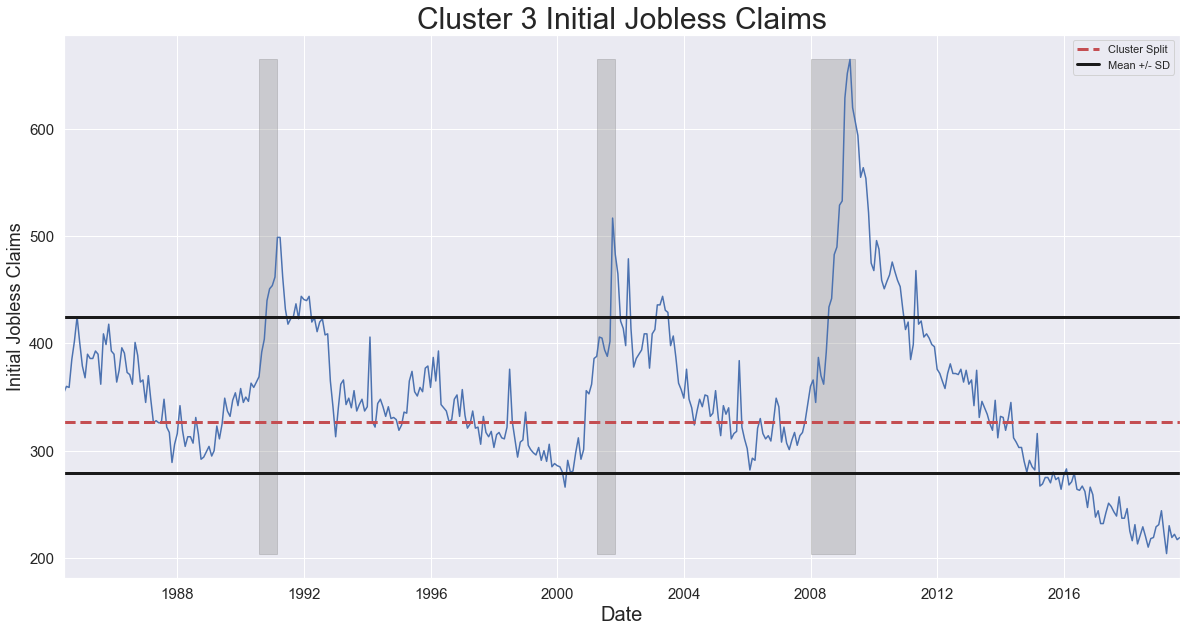

In [22]:
plot_cluster(ijc.index,ijc['Initial Jobless Claims'], 'Initial Jobless Claims', 
            clow = 327, chigh = 425, mlow = 278.96136001854074, mhigh = 424.622752130992 )

###  NAPMPMI Index

In [23]:
ni = df2[['Dates', 'NAPMPMI Index']].set_index('Dates')
ni.head()

,NAPMPMI Index
Dates,
1984-01-31,60.5
1984-02-29,61.3
1984-03-31,58.9
1984-04-30,61.0
1984-05-31,58.6


In [24]:
X5 = ni['NAPMPMI Index'].values.reshape(-1,1)
sc5 = MinMaxScaler()
X_scaled5 = sc5.fit_transform(X5)
X_scaled5[:3]

array([[0.96654275],
       [0.99628253],
       [0.9070632 ]])

In [25]:
kmeans_ni = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred_ni = kmeans_ni.fit_predict(X_scaled5)
ni['label_3'] = pred_ni
score = silhouette_score(X_scaled5, pred_ni, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.5674690486888679


In [26]:
### range of Clusters
print(ni.groupby('label_3').agg(['max', 'min']))
print('=='*40)

mm = ni['NAPMPMI Index'].mean()
sd = ni['NAPMPMI Index'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)

        NAPMPMI Index      
                  max   min
label_3                    
0                54.1  47.7
1                61.4  54.2
2                47.5  34.5
Mean: 52.460046728971925
STD: +/- 4.748007544416856
Upper: 57.20805427338878
Lower: 47.71203918455507


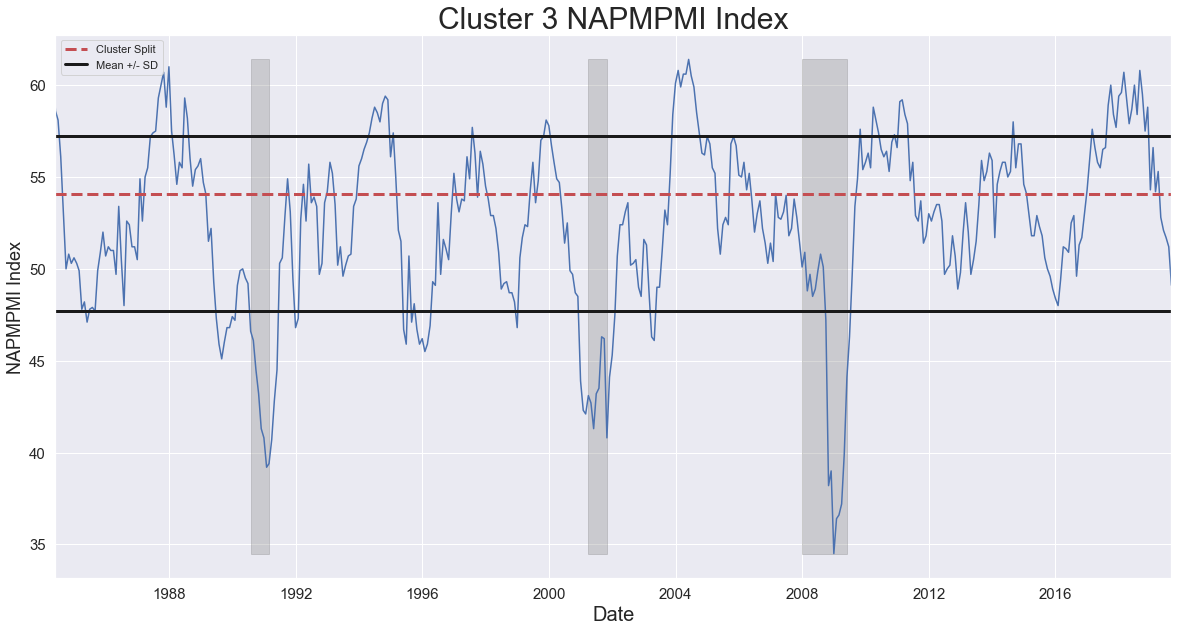

In [27]:
plot_cluster(ni.index,  ni['NAPMPMI Index'], 'NAPMPMI Index', clow = 47.7, chigh = 54.1, 
            mlow = 47.71203918455507, mhigh = 57.20805427338878)

### GDP Index

In [28]:
gdp = df2[['Dates', 'GDP QOQ Index']].set_index('Dates')
gdp.head()

,GDP QOQ Index
Dates,
1984-01-31,8.6
1984-02-29,8.6
1984-03-31,8.1
1984-04-30,8.1
1984-05-31,8.1


In [29]:
X6 = gdp['GDP QOQ Index'].values.reshape(-1,1)
sc6 = MinMaxScaler()
X_scaled6 = sc6.fit_transform(X6)
X_scaled6[:3]

array([[1.        ],
       [1.        ],
       [0.97058824]])

In [30]:
kmeans_gdp = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred_gdp = kmeans_gdp.fit_predict(X_scaled6)
gdp['label_3'] = pred_gdp
score = silhouette_score(X_scaled6, pred_gdp, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.5256461233171265


In [31]:
### range of Clusters
print(gdp.groupby('label_3').agg(['max', 'min']))
print('=='*40)

mm = gdp['GDP QOQ Index'].mean()
sd = gdp['GDP QOQ Index'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)

        GDP QOQ Index     
                  max  min
label_3                   
0                 8.6  3.7
1                 3.6 -0.1
2                -0.6 -8.4
Mean: 2.771028037383178
STD: +/- 2.361944951173429
Upper: 5.132972988556608
Lower: 0.409083086209749


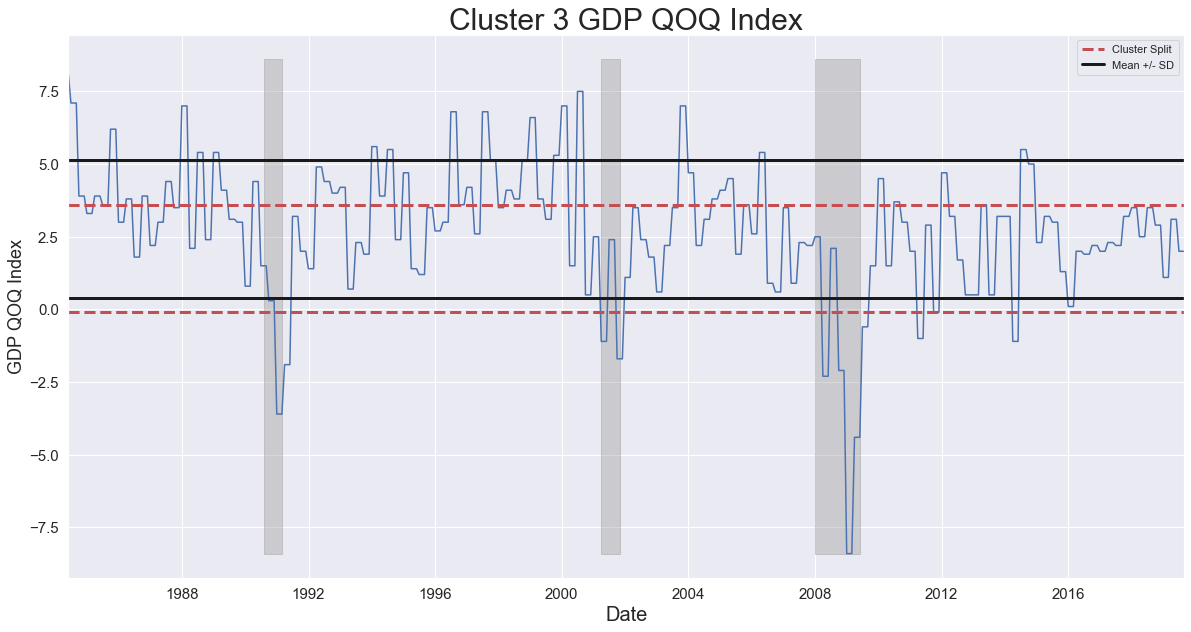

In [32]:
plot_cluster(gdp.index, gdp['GDP QOQ Index'],'GDP QOQ Index', clow = -0.1, chigh =  3.6 , 
            mlow =  0.409083086209749, mhigh = 5.132972988556608 )

### 10 minus 2

In [33]:
#df5 = pd.read_csv('10YEAR_2YEAR_diff.csv')
#df5['DATE'] = pd.to_datetime(df5['DATE'])
min2 = df2[['Dates', 'Diff_2_10']].set_index('Dates')
min2.head()

,Diff_2_10
Dates,
1984-01-31,1.05
1984-02-29,1.01
1984-03-31,0.94
1984-04-30,0.94
1984-05-31,0.65


In [34]:
X8 = min2['Diff_2_10'].values.reshape(-1,1)
sc8 = MinMaxScaler()
X_scaled8 = sc8.fit_transform(X8)
X_scaled8[:3]

array([[0.45061728],
       [0.4382716 ],
       [0.41666667]])

In [35]:
kmeans_min2 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred_min2 = kmeans_min2.fit_predict(X_scaled8)
min2['label_3'] = pred_min2
score = silhouette_score(X_scaled8, pred_min2, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.6066267109127415


In [36]:
### range of Clusters
print(min2.groupby('label_3').agg(['max', 'min']))
print('=='*40)

mm = min2['Diff_2_10'].mean()
sd = min2['Diff_2_10'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)


        Diff_2_10      
              max   min
label_3                
0            2.83  1.70
1            0.69 -0.41
2            1.69  0.73
Mean: 1.1062149532710284
STD: +/- 0.8422058527566539
Upper: 1.9484208060276824
Lower: 0.26400910051437443


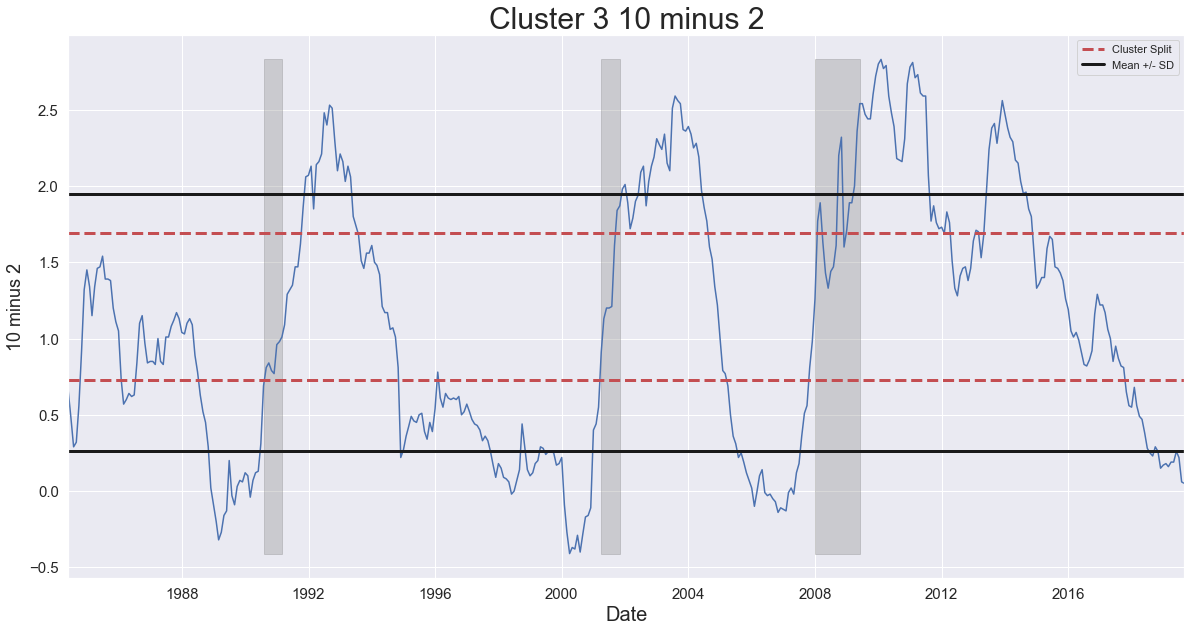

In [37]:
plot_cluster(min2.index, min2['Diff_2_10'], '10 minus 2', clow = 0.73, chigh = 1.69,
            mlow =0.26400910051437443, mhigh = 1.9484208060276824 )

### 10 year minus 3 month

In [38]:
m3 = pd.read_csv('10_minus_3m.csv')
m3['Dates'] = pd.to_datetime(m3.Dates)
m3 = m3[['Dates', 'T10Y3M']].set_index('Dates')
m3.dropna(inplace = True)
m3 = m3[1:]
m3.head()

,T10Y3M
Dates,
1984-01-31,2.382632
1984-02-29,2.429545
1984-03-31,2.560500
1984-04-30,3.185455
1984-05-31,3.302381


In [39]:
X9 = m3[ 'T10Y3M'].values.reshape(-1,1)
sc9 = MinMaxScaler()
X_scaled9 = sc9.fit_transform(X9)
X_scaled9[:3]

array([[0.70283032],
       [0.71353869],
       [0.74342986]])

In [40]:
kmeans_m3 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
pred_m3 = kmeans_m3.fit_predict(X_scaled9)
m3['label_3'] = pred_m3
score = silhouette_score(X_scaled9, pred_m3, metric='euclidean', random_state = 0)
print('Silhouette:',score)

Silhouette: 0.579038597960033


In [41]:
print(m3.groupby('label_3').agg(['max', 'min']))
print('=='*40)

mm = m3[ 'T10Y3M'].mean()
sd = m3[ 'T10Y3M'].std()
u1 = sd + mm
low1 = mm - sd
print('Mean:', mm)
print('STD: +/-', sd)
print('Upper:', u1)
print('Lower:', low1)

           T10Y3M          
              max       min
label_3                    
0        3.684545  2.257273
1        2.249500  0.961818
2        0.934000 -0.696500
Mean: 1.7718166990514008
STD: +/- 1.115479932057839
Upper: 2.8872966311092396
Lower: 0.6563367669935618


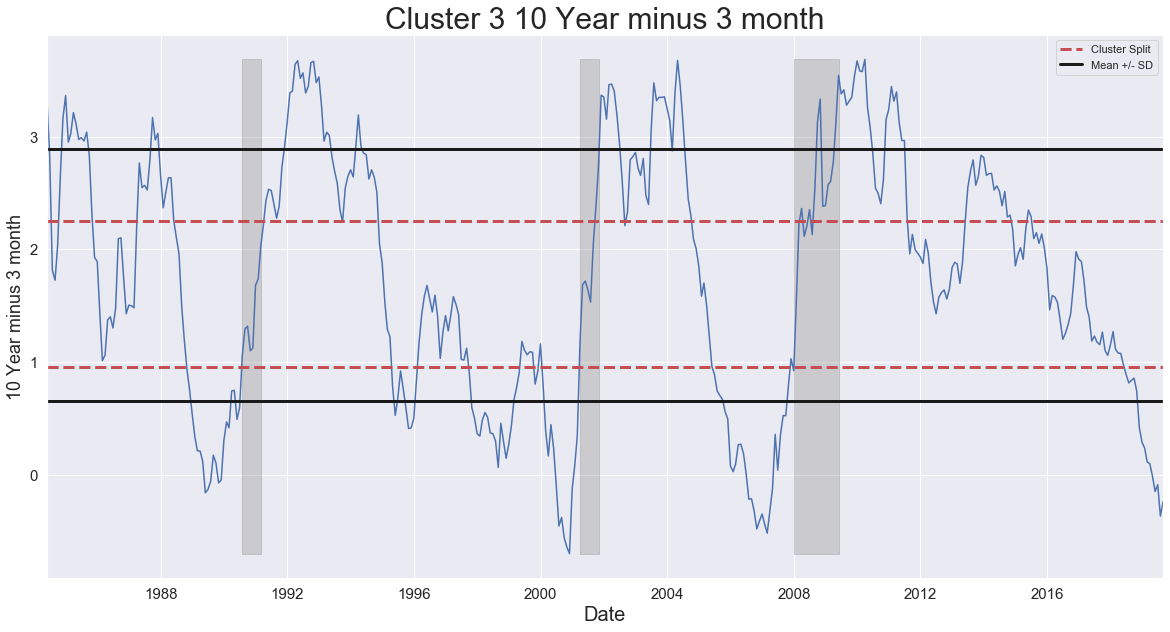

In [42]:
plot_cluster(m3.index,  m3[ 'T10Y3M'], '10 Year minus 3 month', clow = 0.961818, chigh = 2.249500,
            mlow =0.6563367669935618, mhigh = 2.8872966311092396 )

### Rules Plots

In [43]:
recs  =  df2[['Dates', 'Non Farm Payroll', 'Diff_2_10']].set_index('Dates')
recs3 = pd.concat([recs, m3], axis = 1).drop('label_3', axis = 1)
recs3
recs3['label_rec'] = np.where(((recs3['Non Farm Payroll'] < -56) & ((recs3['Diff_2_10'] > 0.73) & (recs3['Diff_2_10'] < 1.69)) & 
                               (recs3['T10Y3M'] > 0.961818)), 1,0)

In [44]:
usrec2 = pd.read_csv('rec_data.csv')
usrec2 = usrec2[['Dates','USREC']]
usrec2['Dates'] = pd.to_datetime(usrec2.Dates)
usrec2['count'] = (usrec2.USREC.diff(1) != 0).astype('int').cumsum()
rec_data33 = pd.DataFrame({'BeginDate' : usrec2.groupby('count').Dates.first(), 
              'EndDate' : usrec2.groupby('count').Dates.last(),
              'Consecutive' : usrec2.groupby('count').size(), 
              'Economy' : usrec2.groupby('count').USREC.first()}).reset_index(drop=True)
rec_data33[rec_data33['Economy'] == 1]

,BeginDate,EndDate,Consecutive,Economy
1,1990-07-31,1991-02-28,8,1
3,2001-03-31,2001-10-31,8,1
5,2007-12-31,2009-05-31,18,1


In [45]:
recs3 = recs3.reset_index()
recs3[recs3['label_rec'] == 1].head()

,Dates,Non Farm Payroll,Diff_2_10,T10Y3M,label_rec
79,1990-08-31,-207,0.81,1.295263,1
80,1990-09-30,-97,0.84,1.319545,1
81,1990-10-31,-153,0.79,1.101500,1
82,1990-11-30,-154,0.77,1.125500,1
84,1991-01-31,-111,0.98,1.738421,1


In [46]:
print('Actaul - Predicted')
print(' ')
print('1990 Recession')
print('Actaul:', rec_data33.at[1,'BeginDate'])
print('Predicted:',recs3.at[79,'Dates'] )
print('Actual - Predicted :', get_months(rec_data33.at[1,'BeginDate'],recs3.at[79,'Dates']))
print('==' * 20)
print('2001 Recession')
print('Actaul:', rec_data33.at[3,'BeginDate'])
print('Predicted:',recs3.at[207,'Dates'] )
print('Actual - Predicted :', get_months(rec_data33.at[3,'BeginDate'], recs3.at[207,'Dates']))
print('==' * 20)
print('2007 - 2008 Recession')
print('Actaul:', rec_data33.at[5,'BeginDate'])
print('Predicted:',recs3.at[291,'Dates'])
print('Actual - Predicted :',get_months(rec_data33.at[5,'BeginDate'],recs3.at[291,'Dates']))
print('==' * 20)

Actaul - Predicted
 
1990 Recession
Actaul: 1990-07-31 00:00:00
Predicted: 1990-08-31 00:00:00
Actual - Predicted : -1
2001 Recession
Actaul: 2001-03-31 00:00:00
Predicted: 2001-04-30 00:00:00
Actual - Predicted : -1
2007 - 2008 Recession
Actaul: 2007-12-31 00:00:00
Predicted: 2008-04-30 00:00:00
Actual - Predicted : -4


### Number of Months under 0.26 10 year minus 2 year

In [47]:
min2.reset_index(inplace = True)

In [48]:
min2['in_rec'] = np.where(min2['Diff_2_10'] < 0.26400910051437443, 1,0)
min2['count'] = (min2.in_rec.diff(1) != 0).astype('int').cumsum()
min10 = pd.DataFrame({'BeginDate' : min2.groupby('count').Dates.first(), 
               'EndDate' : min2.groupby('count').Dates.last(),
               'Consecutive' : min2.groupby('count').size(), 
               'Economy' : min2.groupby('count').in_rec.first()}).reset_index(drop=True)
min10[(min10['Economy'] == 1) & (min10['Consecutive'] > 12)]

,BeginDate,EndDate,Consecutive,Economy
1,1988-11-30,1990-05-31,19,1
9,1999-06-30,2000-11-30,18,1
11,2005-07-31,2007-06-30,24,1


### Number of Months From above 0.26 tell Recession for 10 Year minus 2 year

In [64]:
print('Time from above 0.26 till recession in months')
print(' ')
print('1990 Recession')
print('Time tell recession:', get_months(rec_data33.at[1,'BeginDate'], min10.at[1,'EndDate']))
print('==' * 20)
print('2001 Recession')
print('Time tell recession:', get_months(rec_data33.at[3,'BeginDate'], min10.at[9,'EndDate']))
print('==' * 20)
print('2007-2008 Recession')
print('Time tell recession:', get_months(rec_data33.at[5,'BeginDate'], min10.at[11,'EndDate']))
print('==' * 20)

Time from above 0.26 till recession in months
 
1990 Recession
Time tell recession: 2
2001 Recession
Time tell recession: 4
2007-2008 Recession
Time tell recession: 6


### Number of Months under 0.65 10 year minus 3 month

In [50]:
m3.reset_index(inplace = True)
m3.head()

,Dates,T10Y3M,label_3
0,1984-01-31,2.382632,0
1,1984-02-29,2.429545,0
2,1984-03-31,2.560500,0
3,1984-04-30,3.185455,0
4,1984-05-31,3.302381,0


In [51]:
m3['in_rec'] = np.where(m3['T10Y3M'] < 0.6563367669935618, 1,0)
m3['count'] = (m3.in_rec.diff(1) != 0).astype('int').cumsum()
m10 = pd.DataFrame({'BeginDate' : m3.groupby('count').Dates.first(), 
               'EndDate' : m3.groupby('count').Dates.last(),
               'Consecutive' : m3.groupby('count').size(), 
               'Economy' : m3.groupby('count').in_rec.first()}).reset_index(drop=True)
m10[(m10['Economy'] == 1) & (m10['Consecutive'] > 12)]
m10

,BeginDate,EndDate,Consecutive,Economy
0,1984-01-31,1988-11-30,59,0
1,1988-12-31,1990-02-28,15,1
2,1990-03-31,1990-04-30,2,0
3,1990-05-31,1990-06-30,2,1
4,1990-07-31,1995-04-30,58,0
5,1995-05-31,1995-05-31,1,1
6,1995-06-30,1995-08-31,3,0
7,1995-09-30,1995-12-31,4,1
8,1996-01-31,1997-09-30,21,0
9,1997-10-31,1999-01-31,16,1


### Number of Months From above 0.65 tell Recession for 10 Year minus 3 month

In [63]:
print('Time from above 0.65 till recession in months')
print(' ')
print('1990 Recession')
print('Went above at', m10.at[1,'EndDate'])
print('Time tell recession:', get_months(rec_data33.at[1,'BeginDate'], m10.at[1,'EndDate']))
print('or')
print('Went above at', m10.at[3,'EndDate'])
print('Time tell recession:', get_months(rec_data33.at[1,'BeginDate'], m10.at[3,'EndDate']))
print('==' * 20)
print('2001 Recession')
print('Time tell recession:', get_months(rec_data33.at[3,'BeginDate'], m10.at[11,'EndDate']))
print('==' * 20)
print('2007-2008 Recession')
print('Time tell recession:', get_months(rec_data33.at[5,'BeginDate'], m10.at[13,'EndDate']))
print('==' * 20)

Time from above 0.65 till recession in months
 
1990 Recession
Went above at 1990-02-28 00:00:00
Time tell recession: 5
or
Went above at 1990-06-30 00:00:00
Time tell recession: 1
2001 Recession
Time tell recession: 1
2007-2008 Recession
Time tell recession: 3


### Both 10 minus 2 year and 10 minus 3 month

In [53]:
m3_2 = m3[['Dates', 'T10Y3M']].set_index('Dates')
min2_2 = min2[['Dates', 'Diff_2_10']].set_index('Dates')
df20 = pd.concat([m3_2, min2_2], axis = 1)
df20.reset_index(inplace = True)
df20.tail()

,Dates,T10Y3M,Diff_2_10
423,2019-04-30,-0.008182,0.19
424,2019-05-31,-0.145500,0.26
425,2019-06-30,-0.085909,0.22
426,2019-07-31,-0.364091,0.06
427,2019-08-31,-0.235000,0.05


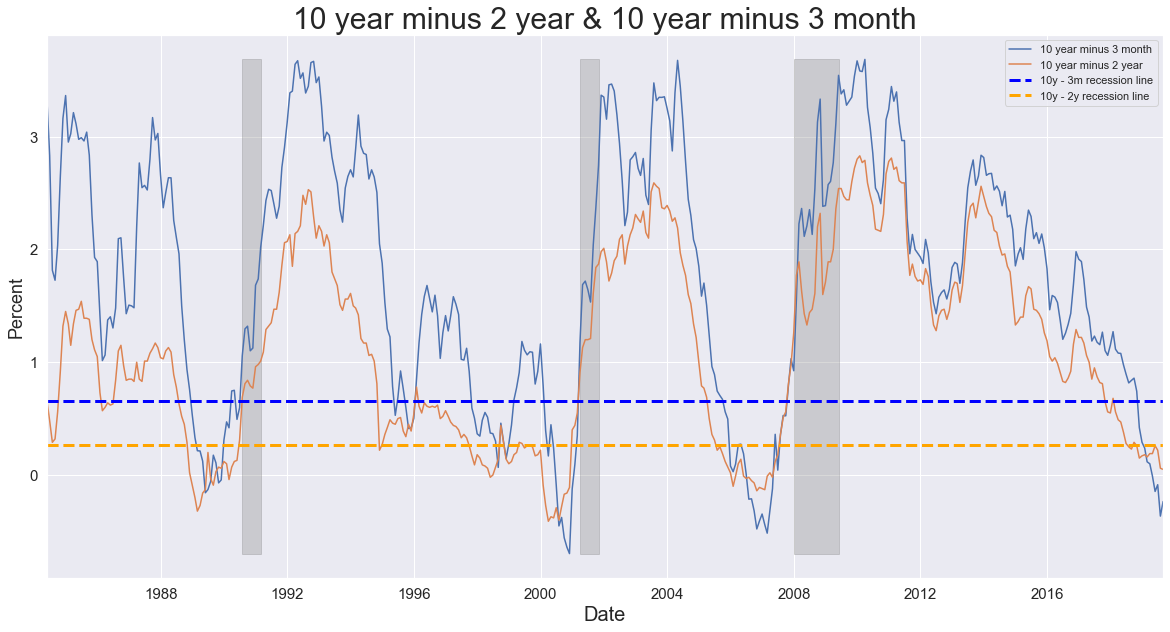

In [54]:
plt.figure(figsize = (20,10))
plt.plot(df20.Dates, df20.T10Y3M, label = '10 year minus 3 month')
plt.plot(df20.Dates, df20.Diff_2_10, label = '10 year minus 2 year')
plt.title('10 year minus 2 year & 10 year minus 3 month', fontsize = 30)
plt.axhline(0.6563367669935618, color='blue', linestyle='--',lw =3, label ='10y - 3m recession line')
plt.axhline(0.26400910051437443, color='orange', linestyle='--',lw =3, label = '10y - 2y recession line')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Percent', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.fill_between(usrec.index, min(df20.T10Y3M), max(df20.T10Y3M), where=usrec['USREC'].values, color='gray', alpha=0.3)
plt.xlim(df20.Dates[4],df20.Dates[427])
plt.legend()

In [55]:
df20['in_rec'] = np.where((df20['T10Y3M'] > 0.6563367669935618) & (df20['Diff_2_10'] > 0.26400910051437443), 1,0)
df20['count'] = (df20.in_rec.diff(1) != 0).astype('int').cumsum()
df21 = pd.DataFrame({'BeginDate' : df20.groupby('count').Dates.first(), 
               'EndDate' : df20.groupby('count').Dates.last(),
               'Consecutive' : df20.groupby('count').size(), 
               'Economy' : df20.groupby('count').in_rec.first()}).reset_index(drop=True)
df21[(df21['Economy'] == 1) ]

,BeginDate,EndDate,Consecutive,Economy
0,1984-01-31,1988-10-31,58,1
2,1990-07-31,1994-10-31,52,1
4,1994-12-31,1995-04-30,5,1
6,1995-06-30,1995-08-31,3,1
8,1996-01-31,1997-08-31,20,1
10,1999-04-30,1999-05-31,2,1
12,2001-03-31,2005-06-30,52,1
14,2007-10-31,2018-06-30,129,1
16,2018-09-30,2018-09-30,1,1


In [62]:
print('Time from above 0.26 10-2 & 0.65 10y-3m till recession in months')
print(' ')
print('1990 Recession')
print('Time tell recession:', get_months(rec_data33.at[1,'BeginDate'], df21.at[2,'BeginDate']))
print('==' * 20)
print('2001 Recession')
print('Time tell recession:', get_months(rec_data33.at[3,'BeginDate'], df21.at[12,'BeginDate']))
print('==' * 20)
print('2007-2008 Recession')
print('Time tell recession:', get_months(rec_data33.at[5,'BeginDate'], df21.at[14,'BeginDate']))
print('==' * 20)

Time from above 0.26 10-2 & 0.65 10y-3m till recession in months
 
1990 Recession
Time tell recession: 0
2001 Recession
Time tell recession: 0
2007-2008 Recession
Time tell recession: 2


In [57]:
print('Prediction of both above 0.26 10-2 & 0.65 10y-3m months')
print(' ')
print('1990 Recession')
print('Actual:',rec_data33.at[1,'BeginDate'])
print('Predicted:',df21.at[2,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[1,'BeginDate'], df21.at[2,'BeginDate']))
print('==' * 20)
print('2001 Recession')
print('Actual:',rec_data33.at[3,'BeginDate'])
print('Predicted:',df21.at[12,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[3,'BeginDate'], df21.at[12,'BeginDate']))
print('==' * 20)
print('2007-2008 Recession')
print('Actual:',rec_data33.at[5,'BeginDate'])
print('Predicted:',df21.at[14,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[5,'BeginDate'], df21.at[14,'BeginDate']))
print('==' * 20)

Prediction of both above 0.26 10-2 & 0.65 10y-3m months
 
1990 Recession
Actual: 1990-07-31 00:00:00
Predicted: 1990-07-31 00:00:00
Actual - Predicted : 0
2001 Recession
Actual: 2001-03-31 00:00:00
Predicted: 2001-03-31 00:00:00
Actual - Predicted : 0
2007-2008 Recession
Actual: 2007-12-31 00:00:00
Predicted: 2007-10-31 00:00:00
Actual - Predicted : 2


### Recession Over

In [58]:
rec4 = recs3[['Dates', 'Non Farm Payroll','Diff_2_10', 'T10Y3M']]
rec4['out_rec'] = np.where(((rec4.Diff_2_10 > 1.69) & (rec4.Diff_2_10 > 2.24)),1,0)
rec4['count'] = (rec4.out_rec.diff(1) != 0).astype('int').cumsum()
df24 = pd.DataFrame({'BeginDate' : rec4.groupby('count').Dates.first(), 
               'EndDate' : rec4.groupby('count').Dates.last(),
               'Consecutive' : rec4.groupby('count').size(), 
               'Economy' : rec4.groupby('count').out_rec.first()}).reset_index(drop=True)
df24

,BeginDate,EndDate,Consecutive,Economy
0,1984-01-31,1992-05-31,101,0
1,1992-06-30,1992-10-31,5,1
2,1992-11-30,2002-11-30,121,0
3,2002-12-31,2003-01-31,2,1
4,2003-02-28,2003-02-28,1,0
5,2003-03-31,2003-03-31,1,1
6,2003-04-30,2003-05-31,2,0
7,2003-06-30,2004-03-31,10,1
8,2004-04-30,2008-09-30,54,0
9,2008-10-31,2008-10-31,1,1


In [59]:
print('Out of Recession')
print(' ')
print('1990 Recession')
print('Actual:',rec_data33.at[1,'EndDate'])
print('Predicted:',df24.at[1,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[1,'EndDate'], df24.at[1,'BeginDate']))
print('==' * 20)
print('2001 Recession')
print('Actual:',rec_data33.at[3,'EndDate'])
print('Predicted:',df24.at[3,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[3,'EndDate'], df24.at[3,'BeginDate']))
print('==' * 20)
print('2007-2008 Recession')
print('Actual:',rec_data33.at[5,'EndDate'])
print('Predicted:',df24.at[9,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[5,'EndDate'], df24.at[9,'BeginDate']))
print('or')
print('Actual:',rec_data33.at[5,'EndDate'])
print('Predicted:',df24.at[11,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[5,'EndDate'], df24.at[11,'BeginDate']))
print('==' * 20)

Out of Recession
 
1990 Recession
Actual: 1991-02-28 00:00:00
Predicted: 1992-06-30 00:00:00
Actual - Predicted : -16
2001 Recession
Actual: 2001-10-31 00:00:00
Predicted: 2002-12-31 00:00:00
Actual - Predicted : -14
2007-2008 Recession
Actual: 2009-05-31 00:00:00
Predicted: 2008-10-31 00:00:00
Actual - Predicted : 7
or
Actual: 2009-05-31 00:00:00
Predicted: 2009-04-30 00:00:00
Actual - Predicted : 1


### GDP & NAPMPMI Index

In [60]:
rec5 = df2[['Dates', 'NAPMPMI Index', 'GDP QOQ Index']]
rec5['out_rec'] = np.where(((rec5['NAPMPMI Index'] > 47.7) & (rec5['GDP QOQ Index'] > 0)) ,1,0)
rec5['count'] = (rec5.out_rec.diff(1) != 0).astype('int').cumsum()
df25 = pd.DataFrame({'BeginDate' : rec5.groupby('count').Dates.first(), 
               'EndDate' : rec5.groupby('count').Dates.last(),
               'Consecutive' : rec5.groupby('count').size(), 
               'Economy' : rec5.groupby('count').out_rec.first()}).reset_index(drop=True)
df25

,BeginDate,EndDate,Consecutive,Economy
0,1984-01-31,1985-04-30,16,1
1,1985-05-31,1985-05-31,1,0
2,1985-06-30,1985-07-31,2,1
3,1985-08-31,1985-08-31,1,0
4,1985-09-30,1989-05-31,45,1
5,1989-06-30,1990-01-31,8,0
6,1990-02-28,1990-06-30,5,1
7,1990-07-31,1991-05-31,11,0
8,1991-06-30,1991-11-30,6,1
9,1991-12-31,1992-01-31,2,0


In [71]:
print('Out of Recession')
print(' ')
print('1990 Recession')
print('Actual:',rec_data33.at[1,'EndDate'])
print('Predicted:',df25.at[8,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[1,'EndDate'], df25.at[8,'BeginDate']))
print('==' * 20)
print('2001 Recession')
print('Actual:',rec_data33.at[3,'EndDate'])
print('Predicted:',df25.at[20,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[3,'EndDate'], df25.at[20,'BeginDate']))
print('==' * 20)
print('Actual:',rec_data33.at[5,'EndDate'])
print('Predicted:',df25.at[26,'BeginDate'] )
print('Actual - Predicted :', get_months(rec_data33.at[5,'EndDate'], df25.at[26,'BeginDate']))
print('==' * 20)

Out of Recession
 
1990 Recession
Actual: 1991-02-28 00:00:00
Predicted: 1991-06-30 00:00:00
Actual - Predicted : -4
2001 Recession
Actual: 2001-10-31 00:00:00
Predicted: 2002-02-28 00:00:00
Actual - Predicted : -4
Actual: 2009-05-31 00:00:00
Predicted: 2009-09-30 00:00:00
Actual - Predicted : -4
